## Project: Recommendation System


Problem Statement:

Build your own recommendation system for products on an e-commerce website like Amazon.com.

Dataset columns - first three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.

Source - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/)  The repository has several datasets. For this case study, we are using the Electronics dataset.

 

Please do the analysis based on steps( 1 to 8) as given below - 

Steps -

Read and explore the given dataset.  ( Rename column/add headers, plot histograms, find data characteristics)
Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )
Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)
Build Popularity Recommender model.
Build Collaborative Filtering model.
Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models.
Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.
Summarise your insights.
 

Please Note - 

If you are facing any memory issue while working on this project, create a small subset (Let’s say 10% of data) and work on it.
If you are stuck at the model evaluation part of this project.
Please refer to below links - 

https://surprise.readthedocs.io/en/stable/accuracy.html
http://surpriselib.com/ - Getting started, example

In [1]:
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
colnames=['userId', 'productId', 'ratings', 'Time'] 
ratings_df = pd.read_csv('ratings_Electronics.csv',names=colnames, header=None)
ratings_df.head()

,userId,productId,ratings,Time
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [3]:
del ratings_df['Time']
ratings_df.head(1)

,userId,productId,ratings
0,AKM1MP6P0OYPR,0132793040,5.0


In [4]:
ratings_df.shape

(7824482, 3)

In [7]:
print("\033[94m\033[1m1. Dimension of dataset :\x1b[0m",list(ratings_df.shape )[0] ,
      " Rows &",list(ratings_df.shape )[1] ," Columns")
print("\033[94m\033[1m2. Column Names:\x1b[0m")
for i,col in enumerate(ratings_df.columns.tolist(),start=1):
    print (" {}.{} ".format(i,col))
print("\033[94m\033[1m3. There is/are \x1b[0m", sum(ratings_df.isnull().values.ravel()),
       "\033[94m\033[1mmissing value(s) in the data set.\x1b[0m")
print( ratings_df.isnull().sum())     
print("\033[94m\033[1m4. Data Info:\x1b[0m")
print("-"*50)
print(ratings_df.info())

1. Dimension of dataset : 7824482  Rows & 3  Columns
2. Column Names:
 1.userId 
 2.productId 
 3.ratings 
3. There is/are  0 missing value(s) in the data set.
userId       0
productId    0
ratings      0
dtype: int64
4. Data Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userId       object
productId    object
ratings      float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB
None


(array([ 901765.,       0.,  456322.,       0.,       0.,  633073.,
              0., 1485781.,       0., 4347541.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

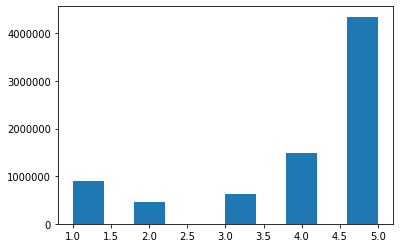

In [23]:
plt.hist(ratings_df['ratings'])

In [5]:
sub_df = ratings_df.groupby('userId').filter(lambda x : len(x)>50)

In [6]:
sub_df.shape

(122171, 3)

In [19]:
sub_df.rename(columns =  {"ratings": "raw_ratings"}, 
                                 inplace = True) 

Popularity Recommender model

In [86]:
sub_df.groupby('productId')['raw_ratings'].mean().head() 

productId
0594481813    3.0
0970407998    2.5
0972683275    5.0
1400501466    3.0
1400501520    5.0
Name: raw_ratings, dtype: float64

In [87]:
sub_df.groupby('productId')['raw_ratings'].mean().sort_values(ascending=False).head()  

productId
B00LKG1MC8    5.0
B000H8WLKC    5.0
B000HA4EZK    5.0
B004EHZZDW    5.0
B004EI0EG4    5.0
Name: raw_ratings, dtype: float64

In [88]:
sub_df.groupby('productId')['raw_ratings'].count().sort_values(ascending=False).head()  

productId
B0088CJT4U    204
B003ES5ZUU    177
B000N99BBC    163
B007WTAJTO    156
B00829TIEK    146
Name: raw_ratings, dtype: int64

In [91]:
ratings_mean_count = pd.DataFrame(sub_df.groupby('productId')['raw_ratings'].mean()) 
ratings_mean_count['rating_counts'] = pd.DataFrame(sub_df.groupby('productId')['raw_ratings'].count())  
ratings_mean_count.head() 

,raw_ratings,rating_counts
productId,,
0594481813,3.0,1
0970407998,2.5,2
0972683275,5.0,3
1400501466,3.0,5
1400501520,5.0,1


Collaborative Filtering model

In [44]:
tenpercent_df = sub_df.sample(frac = 0.1) 

In [45]:
tenpercent_df.shape

(12217, 3)

In [38]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Dataset,Reader
reader = Reader(rating_scale=(1, 5))

In [46]:
data = Dataset.load_from_df(tenpercent_df[['userId', 'productId', 'raw_ratings']], reader)

In [47]:
trainset, testset = train_test_split(data, test_size=.3)

In [48]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [49]:
test_pred = algo.test(testset)

In [50]:
test_pred

[Prediction(uid='A3G5MOHY1U635N', iid='B00005T3G0', r_ui=5.0, est=5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2AC6GQ24S45GA', iid='B006ID4A0E', r_ui=4.0, est=4.0, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2YYHSORXIHZCS', iid='B003VWJT0G', r_ui=5.0, est=4.254239270260788, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2ZY3S7SD3QO8Z', iid='B00AGBVVI8', r_ui=2.0, est=4.0, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2HPJKM7L4EOQB', iid='B002SBH9B2', r_ui=5.0, est=4.254239270260788, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1VRANSQ0WF1YS', iid='B0000AZK4G', r_ui=5.0, est=5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1UMSB7LAW0RIR', iid='B002ZAVVHY', r_ui=5.0, est=5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3N4I2KRSMACW8', iid='B00BCGRTFK', r_ui=5.0, est=4.254239

In [51]:
accuracy.rmse(test_pred, verbose=True)

RMSE: 1.1370


1.1369980510592077

In [52]:
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [53]:
test_pred = algo.test(testset)

In [84]:
print(accuracy.rmse(test_pred, verbose=True))

RMSE: 1.1370
1.1369980510592077


In [58]:
print("\033[94m\033[1mRecommended 5 new products for the test users\x1b[0m")
print("-"*53)
print(test_pred)

Recommended 5 new products for the test users
-----------------------------------------------------
[Prediction(uid='A3G5MOHY1U635N', iid='B00005T3G0', r_ui=5.0, est=5, details={'actual_k': 0, 'was_impossible': False}), Prediction(uid='A2AC6GQ24S45GA', iid='B006ID4A0E', r_ui=4.0, est=4.0, details={'actual_k': 0, 'was_impossible': False}), Prediction(uid='A2YYHSORXIHZCS', iid='B003VWJT0G', r_ui=5.0, est=4.254239270260788, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}), Prediction(uid='A2ZY3S7SD3QO8Z', iid='B00AGBVVI8', r_ui=2.0, est=4.0, details={'actual_k': 0, 'was_impossible': False}), Prediction(uid='A2HPJKM7L4EOQB', iid='B002SBH9B2', r_ui=5.0, est=4.254239270260788, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}), Prediction(uid='A1VRANSQ0WF1YS', iid='B0000AZK4G', r_ui=5.0, est=5, details={'actual_k': 0, 'was_impossible': False}), Prediction(uid='A1UMSB7LAW0RIR', iid='B002ZAVVHY', r_ui=5.0, est=5, details={'actual_k': 0, 'was_im

In [59]:
Recommended = pd.DataFrame(test_pred) 

In [70]:
Recommended.head()

,uid,iid,r_ui,est,details
0,A3G5MOHY1U635N,B00005T3G0,5.0,5.000000,"{'actual_k': 0, 'was_impossible': False}"
1,A2AC6GQ24S45GA,B006ID4A0E,4.0,4.000000,"{'actual_k': 0, 'was_impossible': False}"
2,A2YYHSORXIHZCS,B003VWJT0G,5.0,4.254239,"{'was_impossible': True, 'reason': 'User and/o..."
3,A2ZY3S7SD3QO8Z,B00AGBVVI8,2.0,4.000000,"{'actual_k': 0, 'was_impossible': False}"
4,A2HPJKM7L4EOQB,B002SBH9B2,5.0,4.254239,"{'was_impossible': True, 'reason': 'User and/o..."


In [72]:
del Recommended[ 'r_ui']
del Recommended[ 'details']

In [76]:
Top5_Recommended_for_testset = Recommended.sort_values(by=['uid', 'est'])

In [77]:
Top5_Recommended_for_testset.head(1)

,uid,iid,est
562,A100UD67AHFODS,B005LS2FS6,4.254239


In [78]:
Top5_Recommended_for_testset.rename(columns =  {"uid":"userId", "est": "Estimated_ratings", "iid":"productId"}, 
                                 inplace = True) 

In [82]:
print("\033[94m\033[1mRecommended 5 new products for the test dataset users\x1b[0m")
print("-"*53)
Top5_Recommended_for_testset

Recommended 5 new products for the test dataset users
-----------------------------------------------------


,userId,productId,Estimated_ratings
562,A100UD67AHFODS,B005LS2FS6,4.254239
847,A100UD67AHFODS,B000J0072M,4.254239
1462,A100UD67AHFODS,B009B0MY6S,4.254239
3029,A100UD67AHFODS,B000RYS3S0,4.254239
3092,A100UD67AHFODS,B0090I9UG8,4.254239
294,A100UD67AHFODS,B005DOK8NW,5.000000
1373,A100WO06OQR8BQ,B009APBZVY,3.000000
2902,A100WO06OQR8BQ,B00E5UHRIO,3.500000
709,A100WO06OQR8BQ,B00016V3VI,4.254239
1776,A100WO06OQR8BQ,B0037UD14C,4.254239


Iinsights Summary: 

The products recommended for the new users by Popularity Recommender model and Build Collaborative Filtering are different. As per the model out put the collaborative filtering recommendations are more robust, dynamic user specific while popularity based recommendations are not user specific.     